In [1]:
# MNIST Classification with PyTorch, TensorBoard, and Weights and Biases (wandb)


In [2]:
import sys
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
# Check Python version
assert sys.version_info >= (3, 6), 'Python 3.6 or higher is required'



In [3]:
# Define a simple neural network



class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(32*32, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
    
    def forward(self, x):
        x = x.view(-1, 32*32)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
class LeNet5_28(nn.Module):
    def __init__(self):
        super(LeNet5_28, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 16*4*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

class Lenet5(nn.Module):
    def __init__(self, use_batch_norm=False):
        super(Lenet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=[5,5])
        self.avg_pool1 = nn.AvgPool2d(kernel_size=[2,2], stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=[5,5])
        self.avg_pool2 = nn.AvgPool2d(kernel_size=[2,2], stride=2)
        self.conv3 = nn.Conv2d(16, 120, kernel_size=[5,5])
        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, 10)
        self.use_batch_norm = use_batch_norm
        if use_batch_norm:
            self.batch_norm1 = nn.BatchNorm2d(6)
            self.batch_norm2 = nn.BatchNorm2d(16)
            self.batch_norm3 = nn.BatchNorm2d(120)
    
    def forward(self, x):
        x = self.conv1(x)
        if self.use_batch_norm:
            x = self.batch_norm1(x)
        x = torch.tanh(x)
        x = self.avg_pool1(x)

        x = self.conv2(x)
        if self.use_batch_norm:
            x = self.batch_norm2(x)
        x = torch.tanh(x)
        x = self.avg_pool2(x)

        x = self.conv3(x)
        if self.use_batch_norm:
            x = self.batch_norm3(x)
        x = torch.tanh(x)

        x = torch.flatten(x, 1)
        x = torch.tanh(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x

In [4]:
# Define hyperparameters
batch_size = 64
learning_rate = 0.01
epochs = 15
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# Load the fashionMNIST dataset
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize each image to 32x32
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


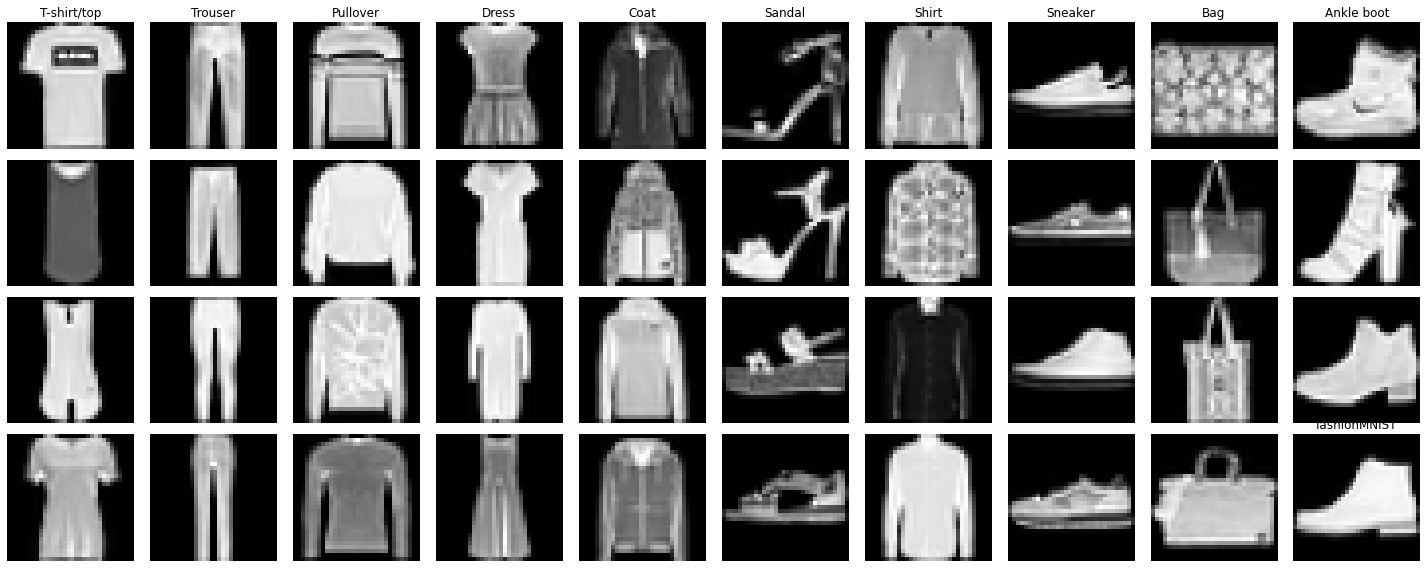

In [6]:
num_samples=4

label_to_images = {i: [] for i in range(10)}
label_names = train_dataset.classes

for image, label in train_dataset:
    if len(label_to_images[label]) < num_samples:
        label_to_images[label].append(image)
    if all(len(images) == num_samples for images in label_to_images.values()):
        break

fig, axes = plt.subplots(num_samples, 10, figsize=(20, num_samples * 2))

for label in range(10):
    for i in range(num_samples):
        image = label_to_images[label][i].squeeze().numpy()
        axes[i, label].imshow(image, cmap='gray')
        axes[i, label].axis('off')
        if i == 0:
            axes[i, label].set_title(label_names[label], fontsize=12)

    
plt.tight_layout()
plt.title('fashionMNIST')
plt.show()

In [7]:
# Initialize the network, loss function, and optimizer
model = Lenet5(use_batch_norm= True).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)


In [8]:
# Initialize TensorBoard
writer = SummaryWriter('runs/fashion_mnist')

# Add model graph to TensorBoard
dummy_input = torch.zeros(batch_size, 1, 32, 32)
writer.add_graph(model, dummy_input)

In [9]:
def evaluate_model(model, test_loader):
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    test_accuracy = 100. * correct_test / total_test
    return test_accuracy

In [10]:
# Training loop
# for epoch in tqdm(range(epochs), desc="Epochs"):
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    batch_loader = tqdm(train_loader, desc="Batches")
    for images, labels in batch_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        
        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        train_accuracy = 100. * correct_train / total_train
        batch_loader.set_description(f"Epoch [{epoch+1}/{epochs}] Batch Loss: {loss.item():.4f} Train accuracy: {train_accuracy:.4f}")
        
    # Log the running loss to TensorBoard
    average_loss = running_loss / len(train_loader)
    train_accuracy = 100. * correct_train / total_train
    writer.add_scalar('Loss/Training', average_loss, epoch)
    writer.add_scalar('Accuracy/Training', train_accuracy, epoch)
    
    test_accuracy = evaluate_model(model=model, test_loader=test_loader)
    writer.add_scalar('Accuracy/Test', test_accuracy, epoch)
    
    batch_loader.set_description(f"Epoch [{epoch+1}/{epochs}] Batch Loss: {loss.item():.4f} Train accuracy: {train_accuracy:.4f} Test accuracy: {test_accuracy:.4f}")
    # Update tqdm description
    # tqdm.set_description(f"Epoch [{epoch+1}/{epochs}] Loss: {average_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Test Acc: {test_accuracy:.2f}%")


Epoch [1/15] Batch Loss: 1.7690 Train accuracy: 77.3900: 100%|██████████| 938/938 [00:35<00:00, 26.52it/s]
Epoch [2/15] Batch Loss: 1.7400 Train accuracy: 81.7617: 100%|██████████| 938/938 [00:40<00:00, 23.26it/s]
Epoch [3/15] Batch Loss: 1.5761 Train accuracy: 83.0800: 100%|██████████| 938/938 [00:41<00:00, 22.67it/s]
Epoch [4/15] Batch Loss: 1.5319 Train accuracy: 83.8467: 100%|██████████| 938/938 [00:41<00:00, 22.70it/s]
Epoch [5/15] Batch Loss: 1.5552 Train accuracy: 84.5617: 100%|██████████| 938/938 [00:33<00:00, 27.61it/s]
Epoch [6/15] Batch Loss: 1.6384 Train accuracy: 85.0317:   7%|▋         | 68/938 [00:02<00:28, 30.72it/s]

In [ ]:
# Save the model
torch.save(model.state_dict(), 'mnist_model.pth')


In [ ]:
# Close TensorBoard writer
writer.close()


In [ ]:
# Evaluation on the test set
test_accuracy = evaluate_model(model=model, test_loader=test_loader)
print(f'Accuracy of the model on the 10000 test images: {test_accuracy:.2f}%')


Accuracy of the model on the 10000 test images: 86.43%
